In [1]:
using JuMP, HiGHS
using Plots; plotly();
using VegaLite  # to make some nice plots
using DataFrames, CSV, PrettyTables
using FileIO
using PlotlyKaleido
ENV["COLUMNS"]=120;

In [2]:
##########Single-time period, simple generator constraints################


datadir = joinpath("ed_data") 
# Note: joinpath is a good way to create path reference that is agnostic
# to what file system you are using (e.g. whether directories are denoted 
# with a forward or backwards slash).
gen_info = CSV.read(joinpath(datadir,"Generators_data.csv"), DataFrame);
fuels = CSV.read(joinpath(datadir,"Fuels_data.csv"), DataFrame);
loads = CSV.read(joinpath(datadir,"Demand.csv"), DataFrame);
gen_variable = CSV.read(joinpath(datadir,"Generators_variability.csv"), DataFrame);


In [3]:
# Rename all columns to lowercase (by convention)
for f in [gen_info, fuels, loads, gen_variable]
    rename!(f,lowercase.(names(f)))
end
     

In [4]:
# Keep only the columns relevant to our ED model 
# (We'll come back to other columns in our unit commitment notebooks)
select!(gen_info, 1:26, :stor) 
gen_df = outerjoin(gen_info,  fuels, on = :fuel) # load in fuel costs and add to data frame
rename!(gen_df, :cost_per_mmbtu => :fuel_cost)   # rename column for fuel cost
gen_df[ismissing.(gen_df[:,:fuel_cost]), :fuel_cost] .= 0

0-element view(::Vector{Union{Missing, Float64}}, Int64[]) with eltype Union{Missing, Float64}

In [5]:

# create "is_variable" column to indicate if this is a variable generation source (e.g. wind, solar)
# Note: Julia's strict vectorization syntax requires us to create a new variable using the '!' indexing operator
# and the '.=' broadcasting assignment. See: https://julia.guide/broadcasting
gen_df[!, :is_variable] .= false
gen_df[in(["onshore_wind_turbine","small_hydroelectric","solar_photovoltaic"]).(gen_df.resource),
    :is_variable] .= true;

In [6]:

# create full name of generator (including geographic location and cluster number)
#  for use with variable generation dataframe
gen_df.gen_full = lowercase.(gen_df.region .* "_" .* gen_df.resource .* "_" .* string.(gen_df.cluster) .* ".0");

# remove generators with no capacity (e.g. new build options that we'd use if this was capacity expansion problem)
gen_df = gen_df[gen_df.existing_cap_mw .> 0,:];


In [7]:
df = gen_df[1:5,1:5]

Row,r_id,resource,region,existing_cap_mw,num_units
,Int64?,String?,String15?,Float64?,Int64?
1,1,biomass,WEC_SDGE,21.4,20
2,2,hydroelectric_pumped_storage,WEC_SDGE,42.0,2
3,3,natural_gas_fired_combined_cycle,WEC_SDGE,607.1,1
4,4,natural_gas_fired_combined_cycle,WEC_SDGE,30.0,1
5,5,natural_gas_fired_combined_cycle,WEC_SDGE,49.4,1


In [8]:
df = copy(gen_df)
select!(df, 1:5)
df = df[1:5,:]

Row,r_id,resource,region,existing_cap_mw,num_units
,Int64?,String?,String15?,Float64?,Int64?
1,1,biomass,WEC_SDGE,21.4,20
2,2,hydroelectric_pumped_storage,WEC_SDGE,42.0,2
3,3,natural_gas_fired_combined_cycle,WEC_SDGE,607.1,1
4,4,natural_gas_fired_combined_cycle,WEC_SDGE,30.0,1
5,5,natural_gas_fired_combined_cycle,WEC_SDGE,49.4,1


In [9]:

stack(df, 
    [:existing_cap_mw, :num_units], 
    variable_name=:var,
    value_name=:val)
     

Row,r_id,resource,region,var,val
,Int64?,String?,String15?,String,Float64?
1,1,biomass,WEC_SDGE,existing_cap_mw,21.4
2,2,hydroelectric_pumped_storage,WEC_SDGE,existing_cap_mw,42.0
3,3,natural_gas_fired_combined_cycle,WEC_SDGE,existing_cap_mw,607.1
4,4,natural_gas_fired_combined_cycle,WEC_SDGE,existing_cap_mw,30.0
5,5,natural_gas_fired_combined_cycle,WEC_SDGE,existing_cap_mw,49.4
6,1,biomass,WEC_SDGE,num_units,20.0
7,2,hydroelectric_pumped_storage,WEC_SDGE,num_units,2.0
8,3,natural_gas_fired_combined_cycle,WEC_SDGE,num_units,1.0
9,4,natural_gas_fired_combined_cycle,WEC_SDGE,num_units,1.0


In [10]:
gen_variable.hour = mod.(gen_variable.hour .- 9, 8760) .+ 1 
sort!(gen_variable, :hour)
loads.hour = mod.(loads.hour .- 9, 8760) .+ 1
sort!(loads, :hour);

In [11]:
describe(gen_variable)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,hour,4380.5,1,4380.5,8760,0,Int64
2,wec_sdge_biomass_1.0,1.0,1,1.0,1,0,Int64
3,wec_sdge_hydroelectric_pumped_storage_1.0,1.0,1,1.0,1,0,Int64
4,wec_sdge_natural_gas_fired_combined_cycle_1.0,1.0,1,1.0,1,0,Int64
5,wec_sdge_natural_gas_fired_combined_cycle_2.0,1.0,1,1.0,1,0,Int64
6,wec_sdge_natural_gas_fired_combined_cycle_3.0,1.0,1,1.0,1,0,Int64
7,wec_sdge_natural_gas_fired_combined_cycle_4.0,1.0,1,1.0,1,0,Int64
8,wec_sdge_natural_gas_fired_combustion_turbine_1.0,1.0,1,1.0,1,0,Int64
9,wec_sdge_natural_gas_fired_combustion_turbine_2.0,1.0,1,1.0,1,0,Int64


In [12]:
gen_variable_long = stack(gen_variable, 
                        Not(:hour), 
                        variable_name=:gen_full,
                        value_name=:cf);

In [13]:
# Now we have a "long" dataframe; 
# let's look at the first 6 entries of a wind resource for example
first(gen_variable_long[gen_variable_long.gen_full.=="wec_sdge_onshore_wind_turbine_1.0",:],25)

Row,hour,gen_full,cf
,Int64,String,Float64
1,1,wec_sdge_onshore_wind_turbine_1.0,0.1694
2,2,wec_sdge_onshore_wind_turbine_1.0,0.1658
3,3,wec_sdge_onshore_wind_turbine_1.0,0.1502
4,4,wec_sdge_onshore_wind_turbine_1.0,0.1455
5,5,wec_sdge_onshore_wind_turbine_1.0,0.0932
6,6,wec_sdge_onshore_wind_turbine_1.0,0.0717
7,7,wec_sdge_onshore_wind_turbine_1.0,0.0211
8,8,wec_sdge_onshore_wind_turbine_1.0,0.0216
9,9,wec_sdge_onshore_wind_turbine_1.0,0.0216


In [14]:
hr = 20

20

In [15]:
loads_single = loads[loads[:,:hour] .== hr, Not(:hour)]; 
loads_single 

Row,demand
,Int64
1,2409


In [16]:
var_cf_single = gen_variable_long[
    gen_variable_long.hour .== hr, 
    Not(:hour)]

Row,gen_full,cf
,String,Float64
1,wec_sdge_biomass_1.0,1.0
2,wec_sdge_hydroelectric_pumped_storage_1.0,1.0
3,wec_sdge_natural_gas_fired_combined_cycle_1.0,1.0
4,wec_sdge_natural_gas_fired_combined_cycle_2.0,1.0
5,wec_sdge_natural_gas_fired_combined_cycle_3.0,1.0
6,wec_sdge_natural_gas_fired_combined_cycle_4.0,1.0
7,wec_sdge_natural_gas_fired_combustion_turbine_1.0,1.0
8,wec_sdge_natural_gas_fired_combustion_turbine_2.0,1.0
9,wec_sdge_natural_gas_fired_combustion_turbine_3.0,1.0


In [17]:
#3. Create solver function

#=
Function to solve economic dispatch problem (single-time period, single-zone)      #함수정의 3개의 input이 있음
Inputs:
    gen_df -- dataframe with generator info                                       #input1: 발전기 정보 
    loads  -- dataframe with load info                                            #input2: 부하 정보 
    gen_variable -- capacity factors of variable generators (in "long" format)    #input3: 발전기의 용량 요소
Note: it is always a good idea to include a comment blog describing your
function's inputs clearly!
=#
function economic_dispatch_single(gen_df, loads, gen_variable)                   #함수정의 
    ED = Model(HiGHS.Optimizer) # You could use Clp as well, with Clp.Optimizer   #ED는 최적값을 찾는 SOLVER
    
    #발전기 정보에 variable인지 판단하는 칼럼이 존재
    #is_variable이 1(true)이면 G_var에 넣는다
    #is_variable이 0(false)이면 G_nonvar에 넣는다
    #  :r_id는 r_id 열을 불러 오라는 말이다 
    #G_var, G_nonvar, G 는 모두 발전기에대한 일련번호만 들어있는 변수이다 
    
    # Define sets based on data
      # A set of all variable generators
    G_var = gen_df[gen_df[!,:is_variable] .== 1,:r_id]                          
      # A set of all non-variable generators                                    
    G_nonvar = gen_df[gen_df[!,:is_variable] .== 0,:r_id]                         
      # Set of all generators
    G = gen_df.r_id                                                            
    # Extract some parameters given the input data
      # Generator capacity factor time series for variable generators
   
    gen_var_cf = innerjoin(gen_variable, 
                    gen_df[gen_df.is_variable .== 1 , 
                        [:r_id, :gen_full, :existing_cap_mw]], 
                    on = :gen_full)
        
    #G는 모든 발전기에 대한 일련번호라고 생각하면 된다 /////모든 발전기다. 변수인지 아닌지 상관없다(중요)
    #의사결정 변수는 발전기이다. 
    
    # Decision variables   
    @variables(ED, begin
        GEN[G]  >= 0     # generation
        # Note: we assume Pmin = 0 for all resources for simplicty here
    end)
    
#=목적함수는 변수가 아닌 발전기(예를 들어 신재생발전기)의 fuel_cost와 heat_rate의 곱과 GEN[i]와 var_om_cost의 곱을 합한것에 
변수인 발전기(가동할것인지 말것인지를 선택할 수 있는 발전기)와 var_om_cost곱한것을 합을 최소화 하는 것이다. (고정비는 생략한다 )=#

    # Objective function
    @objective(ED, Min, 
        sum( (gen_df[i,:heat_rate_mmbtu_per_mwh] * gen_df[i,:fuel_cost] +
            gen_df[i,:var_om_cost_per_mwh]) * GEN[i] 
                        for i in G_nonvar) + 
        sum(gen_df[i,:var_om_cost_per_mwh] * GEN[i] 
                        for i in G_var)
    )

            
     #제약조건1 모든 발전기의 생산량 총합은 부하(수요)량과 같다      
     #제약조건2 변수가 아닌 발전기의 생산량은 해당 발전기의 남은 용량보다 작거나 같아야 한다 
     #제약조건3 변수인 발전기의 생산량은 해당 발전기의 남은 용량과 cf의 곱보다 작아야 한다. 
     #(cf는 정확히 무엇인지는 모르겠으나 0과 1사이 값을 가진다)      
            
    # Demand constraint
    @constraint(ED, cDemand, 
        sum(GEN[i] for i in G) == loads[1,:demand])

    # Capacity constraint (non-variable generation)
    for i in G_nonvar
        @constraint(ED, GEN[i] <= gen_df[i,:existing_cap_mw])
    end

    # Variable generation capacity constraint
    for i in 1:nrow(gen_var_cf)
        @constraint(ED, GEN[gen_var_cf[i,:r_id] ] <= 
                        gen_var_cf[i,:cf] *
                        gen_var_cf[i,:existing_cap_mw])
    end

    #최적 생산량을 찾는 code
    # Solve statement (! indicates runs in place)
    optimize!(ED)
    
    #각 발전기에 대한 일련번호,발전원(발전연료), 발전량에 대한 테이블을 보여줌     
    # Dataframe of optimal decision variables
    solution = DataFrame(
        r_id = gen_df.r_id,
        resource = gen_df.resource,
        gen = value.(GEN).data
        )

    # Return the solution and objective as named tuple
    return (
        solution = solution, 
        cost = objective_value(ED),
    )
end
     

economic_dispatch_single (generic function with 1 method)

In [18]:
#4. Solve and print data

solution = economic_dispatch_single(gen_df, loads_single, var_cf_single);
solution.solution

Running HiGHS 1.4.0 [date: 1970-01-01, git hash: bcf6c0b22]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
1 rows, 21 cols, 21 nonzeros
1 rows, 19 cols, 19 nonzeros
Presolve : Reductions: rows 1(-25); columns 19(-6); elements 19(-31)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     1.2524042600e+04 Pr: 1(1711.68) 0s
          1     6.6868294042e+04 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 1
Objective value     :  6.6868294042e+04
HiGHS run time      :          0.02


Row,r_id,resource,gen
,Int64?,String?,Float64
1,1,biomass,21.4
2,2,hydroelectric_pumped_storage,42.0
3,3,natural_gas_fired_combined_cycle,607.1
4,4,natural_gas_fired_combined_cycle,30.0
5,5,natural_gas_fired_combined_cycle,49.4
6,6,natural_gas_fired_combined_cycle,570.0
7,7,natural_gas_fired_combined_cycle,336.0
8,8,natural_gas_fired_combined_cycle,336.0
9,9,natural_gas_fired_combustion_turbine,91.6


In [19]:
supply_curve = leftjoin(gen_df,
                var_cf_single, 
                on = :gen_full)
supply_curve[!, :varcost] .= 0.0
supply_curve[!, :cap] .= 0.0

# Store varcost of non-variable generators:
I = supply_curve[!,:is_variable] .== 0  # `I` contains indexes to the non-variable generators
supply_curve[I,:varcost] .= 
    supply_curve[I,:heat_rate_mmbtu_per_mwh] .* 
        supply_curve[I,:fuel_cost] .+
    supply_curve[I,:var_om_cost_per_mwh]

# Calculate available capacity for each generator
supply_curve[I,:cap] = supply_curve[I,:existing_cap_mw]

# Store varcost of variable generators (in this case, 0)
I = (supply_curve[:,:is_variable] .== 1) # `I` contains indexes to the variable generators
supply_curve[I,:varcost] = supply_curve[I,:var_om_cost_per_mwh]

# Calculate available capacity for each generator
# (adjusted for variable generation)
supply_curve[I,:cap] = supply_curve[I,:existing_cap_mw] .* supply_curve[I,:cf]

sort!(supply_curve, :varcost);

In [20]:
rectangle(w, h, x, y) = Shape(x .+ [0,w,w,0], y .+ [0,0,h,h])

p = plot(nrow(supply_curve))

marg_gen = 0
marg_price = 0
x = 0
for i in 1:nrow(supply_curve)
    plot!(p, rectangle(supply_curve[i,:cap],
            supply_curve[i,:varcost],x,0), opacity=.5, 
            label = "")
    if (x < loads_single[1,:demand]) && (x + supply_curve[i,:cap] > loads_single[1,:demand])
        marg_gen = i
        marg_price = supply_curve[i,:varcost]
    end
    x = x + supply_curve[i,:cap]
end 
vline!([loads_single[1,:demand]],linecolor="black",linewidth=5,
label = "demand")
hline!([marg_price],linecolor="blue",linewidth=5,
label = "SRMC")
title!("Supply and demand curves")
xlabel!("Capacity")
ylabel!("Marginal cost")
p
     

In [21]:
supply_curve[marg_gen,:]

Row,r_id,resource,region,existing_cap_mw,num_units,cap_size,var_om_cost_per_mwh,var_om_cost_per_mwh_in,fuel,heat_rate_mmbtu_per_mwh,heat_rate_mmbtu_mwh_iqr,heat_rate_mmbtu_mwh_std,min_power,ramp_up_percentage,ramp_dn_percentage,start_cost_per_mw,start_fuel_mmbtu_per_mw,up_time,down_time,self_disch,eff_up,eff_down,ratio_power_to_energy,min_duration,max_duration,cluster,stor,fuel_cost,co2_content_tons_per_mmbtu,is_variable,gen_full,cf,varcost,cap
,Int64?,String?,String15?,Float64?,Int64?,Float64?,Float64?,Int64?,String31,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Int64?,Float64?,Int64?,Int64?,Int64?,Float64?,Float64?,Float64?,Int64?,Int64?,Int64?,Int64?,Float64?,Float64?,Bool,String,Float64?,Float64,Float64
17,22,natural_gas_fired_combustion_turbine,WEC_SDGE,51.3,1,51.3,10.8,0,pacific_naturalgas,11.12,0.0,0.0,0.409,3.78,3.78,113,3.5,1,1,0,1.0,1.0,1.0,0,0,14,0,2.57,0.05306,false,wec_sdge_natural_gas_fired_combustion_turbine_14.0,missing,39.3784,51.3


In [22]:
solution.solution[solution.solution.r_id .== supply_curve[marg_gen,:r_id],
    :gen][1]

15.678599999999925

In [23]:
sol_gen = combine(groupby(solution.solution, :resource), 
            :gen => sum)
# We use the PrettyTable package here to round numbers when displaying
pretty_table(sol_gen, formatters = ft_printf("%5.3f")) 
     

┌──────────────────────────────────────┬──────────┐
│                             resource │  gen_sum │
│                              String? │  Float64 │
├──────────────────────────────────────┼──────────┤
│                              biomass │   21.400 │
│         hydroelectric_pumped_storage │   42.000 │
│     natural_gas_fired_combined_cycle │ 1928.500 │
│ natural_gas_fired_combustion_turbine │  353.179 │
│                 onshore_wind_turbine │   61.777 │
│                  small_hydroelectric │    2.145 │
│                   solar_photovoltaic │    0.000 │
└──────────────────────────────────────┴──────────┘


In [24]:
# we use the copy function to create a copy of the dataframe (as opposed to working with the original)
sol_gen_btm = copy(sol_gen)

# We'll use the same variability profile for BTM solar as the utility-scale solar here (in reality, they would probably differ)
btm = DataFrame(resource = ["solar_photovoltaic_btm"], gen_sum = var_cf_single[var_cf_single.gen_full .== "wec_sdge_solar_photovoltaic_1.0",:cf] * 600)
append!(sol_gen_btm, btm)
pretty_table(sol_gen_btm, formatters = ft_printf("%5.3f")) # We use the PrettyTable package to round numbers when displaying

┌──────────────────────────────────────┬──────────┐
│                             resource │  gen_sum │
│                              String? │  Float64 │
├──────────────────────────────────────┼──────────┤
│                              biomass │   21.400 │
│         hydroelectric_pumped_storage │   42.000 │
│     natural_gas_fired_combined_cycle │ 1928.500 │
│ natural_gas_fired_combustion_turbine │  353.179 │
│                 onshore_wind_turbine │   61.777 │
│                  small_hydroelectric │    2.145 │
│                   solar_photovoltaic │    0.000 │
│               solar_photovoltaic_btm │    0.000 │
└──────────────────────────────────────┴──────────┘


In [25]:
################    Multiple-time period, complex generator constraints with time coupling      ####################

In [33]:
#=
Function to solve economic dispatch problem (multi-time period, single-zone)
Inputs:
    gen_df -- dataframe with generator info
    loads  -- load by time
    gen_variable -- capacity factors of variable generators (in "long" format)
=#
function economic_dispatch_multi(gen_df, loads, gen_variable)
    ED = Model(HiGHS.Optimizer)

    # Define sets based on data
    G_var = gen_df[gen_df[!,:is_variable] .== 1,:r_id] 
    G_nonvar = gen_df[gen_df[!,:is_variable] .== 0,:r_id]
    G = gen_df.r_id
    T = loads.hour

    # Generator capacity factor time series for variable generators
    gen_var_cf = innerjoin(gen_variable, 
                    gen_df[gen_df.is_variable .== 1 , 
                        [:r_id, :gen_full, :existing_cap_mw]], 
                    on = :gen_full)
        
    # Decision variables   
    @variables(ED, begin
        GEN[G, T]  >= 0     # generation
        # Note: we assume Pmin = 0 for all resources for simplicty here
    end)
                
    # Objective function
    @objective(ED, Min, 
        sum( (gen_df[gen_df.r_id .== i,:heat_rate_mmbtu_per_mwh][1] * gen_df[gen_df.r_id .== i,:fuel_cost][1] +
            gen_df[gen_df.r_id .== i,:var_om_cost_per_mwh][1]) * GEN[i,t] 
                        for i in G_nonvar for t in T) + 
        sum(gen_df[gen_df.r_id .== i,:var_om_cost_per_mwh][1] * GEN[i,t] 
                        for i in G_var for t in T)
    )
    
    # Demand constraint
    @constraint(ED, cDemand[t in T], 
        sum(GEN[i,t] for i in G) == loads[loads.hour .== t,:demand][1])

    # Capacity constraints (non-variable generation)
    @constraint(ED, Cap_nonvar[i in G_nonvar, t in T], 
        GEN[i,t] <= gen_df[gen_df.r_id .== i,:existing_cap_mw][1])

    # Variable generation capacity constraints
    @constraint(ED, Cap_var[i in 1:nrow(gen_var_cf)], 
            GEN[gen_var_cf[i,:r_id], gen_var_cf[i,:hour] ] <= 
                        gen_var_cf[i,:cf] *
                        gen_var_cf[i,:existing_cap_mw])
    
    # Solve statement (! indicates runs in place)
    optimize!(ED)

    # Dataframe of optimal decision variables
    # This requires a few extra steps because we are indexing decision variables over two sets: generator and time
    solution = DataFrame(value.(GEN).data, :auto)  # :auto argument asks DataFrames to pick the variable names automatically
    ax1 = value.(GEN).axes[1]
    ax2 = value.(GEN).axes[2]
    cols = names(solution)
    insertcols!(solution, 1, :r_id => ax1)
    solution = stack(solution, Not(:r_id), variable_name=:hour)
    solution.hour = foldl(replace, [cols[i] => ax2[i] for i in 1:length(ax2)], init=solution.hour)
    rename!(solution, :value => :gen)
    solution.hour = convert.(Int64,solution.hour)
    
    # Return the solution and objective as named tuple
    return (
        solution = solution, 
        cost = objective_value(ED),
        status = termination_status(ED)
    )

end
     

economic_dispatch_multi (generic function with 1 method)

In [35]:
n=100
T_period = (n*24+1):((n+1)*24)

loads_multi = loads[in.(loads.hour,Ref(T_period)),:]
gen_variable_multi = gen_variable_long[in.(gen_variable_long.hour,Ref(T_period)),:]

gen_df_sens = copy(gen_df)
gen_df_sens[gen_df_sens.resource .== "solar_photovoltaic",
    :existing_cap_mw] .= 3500

solution = economic_dispatch_multi(gen_df_sens, loads_multi, gen_variable_multi);

Running HiGHS 1.4.0 [date: 1970-01-01, git hash: bcf6c0b22]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
24 rows, 583 cols, 583 nonzeros
24 rows, 522 cols, 522 nonzeros
Presolve : Reductions: rows 24(-600); columns 522(-78); elements 522(-678)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     2.5048085200e+04 Pr: 24(53556.1) 0s
         24     8.0339333085e+05 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 24
Objective value     :  8.0339333085e+05
HiGHS run time      :          0.00


In [48]:
# **Add back in BTM solar and plot results**

sol_gen = innerjoin(solution.solution, 
                    gen_df[!, [:r_id, :resource]], 
                    on = :r_id)
sol_gen = combine(groupby(sol_gen, [:resource, :hour]), 
            :gen => sum)
sol_gen_btm = copy(sol_gen)
sol_gen_btm[sol_gen_btm.resource .== "solar_photovoltaic", :resource] .= "_solar_photovoltaic"
sol_gen_btm[sol_gen_btm.resource .== "onshore_wind_turbine", :resource] .= "_onshore_wind_turbine"
sol_gen_btm[sol_gen_btm.resource .== "small_hydroelectric", :resource] .= "_small_hydroelectric"

btm = DataFrame(resource = repeat(["_solar_photovoltaic_btm"]; outer=length(T_period)), 
    hour = T_period,
    gen_sum = gen_variable_multi[gen_variable_multi.gen_full .== "wec_sdge_solar_photovoltaic_1.0",:cf] * 600)
append!(sol_gen_btm, btm)


Row,resource,hour,gen_sum
,String?,Int64,Float64
1,biomass,2401,21.4
2,hydroelectric_pumped_storage,2401,42.0
3,natural_gas_fired_combined_cycle,2401,1385.11
4,natural_gas_fired_combustion_turbine,2401,0.0
5,_onshore_wind_turbine,2401,163.309
6,_small_hydroelectric,2401,3.18493
7,_solar_photovoltaic,2401,0.0
8,biomass,2402,21.4
9,hydroelectric_pumped_storage,2402,42.0


In [49]:
# Reorder resources
sort!(sol_gen_btm, [:hour, :resource])

#Write output
  # Create a 'results' directory in your current working directory if one does not yet exist
if !isdir("results") 
    mkdir("results")
end
  # Write the outputs to this folder
CSV.write("results/sol_gen_btm.csv",sol_gen_btm)

sol_gen_sum = combine(groupby(sol_gen_btm, [:resource]), 
            :gen_sum => sum)

Row,resource,gen_sum_sum
,String?,Float64
1,_onshore_wind_turbine,2314.42
2,_small_hydroelectric,76.4384
3,_solar_photovoltaic,20546.0
4,_solar_photovoltaic_btm,3522.18
5,biomass,513.6
6,hydroelectric_pumped_storage,1008.0
7,natural_gas_fired_combined_cycle,29733.7
8,natural_gas_fired_combustion_turbine,1240.77


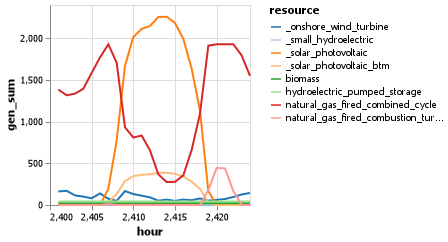

In [50]:
# Plot hourly generation by each resource type
sol_gen_btm |>
@vlplot(:line, 
    x=:hour, y=:gen_sum, 
    color={"resource:n", scale={scheme="category20"}})

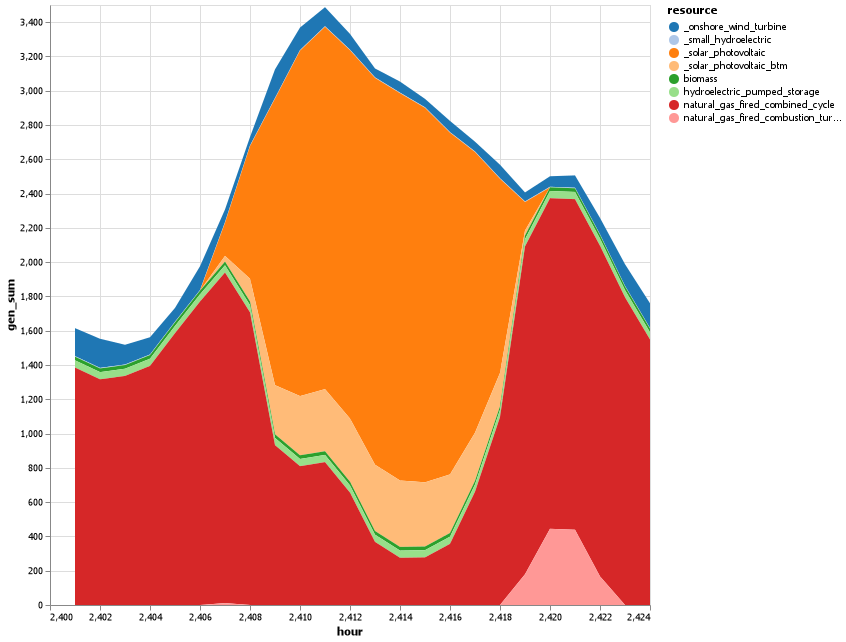

In [51]:
# Plot stacked generation by each resource type
g = sol_gen_btm |>
@vlplot(:area, 
    x=:hour, y={:gen_sum, stack=:zero}, 
    color={"resource:n", scale={scheme="category20"}},
    width=600,height=600) 

In [52]:
# Save this plot to file if you want to
g |> FileIO.save("results/ED_multitime.png")

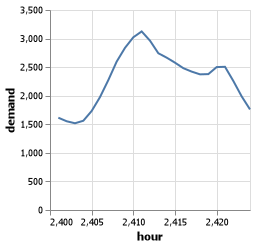

In [53]:
loads_multi |>
@vlplot(:line, 
    x=:hour, y=:demand)

In [39]:
#############          Multiple-time period, complex generator constraints with time coupling        ###############
#=
Function to convert JuMP outputs (technically, AxisArrays) with two-indexes to a dataframe
Inputs:
    var -- JuMP AxisArray (e.g., value.(GEN))
Reference: https://jump.dev/JuMP.jl/v0.19/containers/
=#
function value_to_df_2dim(var)
    solution = DataFrame(var.data, :auto)
    ax1 = var.axes[1]
    ax2 = var.axes[2]
    cols = names(solution)
    insertcols!(solution, 1, :r_id => ax1)
    solution = stack(solution, Not(:r_id), variable_name=:hour)
    solution.hour = foldl(replace, [cols[i] => ax2[i] for i in 1:length(ax2)], init=solution.hour)
    rename!(solution, :value => :gen)
    solution.hour = convert.(Int64,solution.hour)
    return solution
end

value_to_df_2dim (generic function with 1 method)

In [40]:
#=
Function to solve economic dispatch problem (multi-time period, single-zone)
Inputs:
    gen_df -- dataframe with generator info
    loads  -- load by time
    gen_variable -- capacity factors of variable generators (in "long" format)
=#
function economic_dispatch_multi_time(gen_df, loads, gen_variable)
    ED = Model(HiGHS.Optimizer)

    # Define sets based on data
    G_var = gen_df[gen_df[!,:is_variable] .== 1,:r_id] 
    G_nonvar = gen_df[gen_df[!,:is_variable] .== 0,:r_id]
    G = gen_df.r_id
    T = loads.hour
    T_red = loads.hour[1:end-1]  # time periods used for ramp constraints
    
    # Generator capacity factor time series for variable generators
    gen_var_cf = innerjoin(gen_variable, 
                    gen_df[gen_df.is_variable .== 1 , 
                        [:r_id, :gen_full, :existing_cap_mw]], 
                    on = :gen_full)
        
    # Decision variables   
    @variables(ED, begin
        GEN[G, T]  >= 0     # generation
        # Note: we assume Pmin = 0 for all resources for simplicty here
    end)
                
    # Objective function
    @objective(ED, Min, 
        sum( (gen_df[gen_df.r_id .== i,:heat_rate_mmbtu_per_mwh][1] * gen_df[gen_df.r_id .== i,:fuel_cost][1] +
            gen_df[gen_df.r_id .== i,:var_om_cost_per_mwh][1]) * GEN[i,t] 
                        for i in G_nonvar for t in T) + 
        sum(gen_df[gen_df.r_id .== i,:var_om_cost_per_mwh][1] * GEN[i,t] 
                        for i in G_var for t in T)
    )
    
    # Demand constraint
    @constraint(ED, cDemand[t in T], 
        sum(GEN[i,t] for i in G) == loads[loads.hour .== t,:demand][1])

    # Capacity constraints (non-variable generation)
    @constraint(ED, Cap_nonvar[i in G_nonvar, t in T], 
        GEN[i,t] <= gen_df[gen_df.r_id .== i,:existing_cap_mw][1])

    # Variable generation capacity constraints
    @constraint(ED, Cap_var[i in 1:nrow(gen_var_cf)], 
            GEN[gen_var_cf[i,:r_id], gen_var_cf[i,:hour] ] <= 
                        gen_var_cf[i,:cf] *
                        gen_var_cf[i,:existing_cap_mw])
    
    # Ramp up constraints
    @constraint(ED, RampUp[i in G, t in T_red], 
        GEN[i,t+1] - GEN[i,t] <= gen_df[gen_df.r_id .== i,:existing_cap_mw][1] * 
                                 gen_df[gen_df.r_id .== i,:ramp_up_percentage][1] )

    # Ramp down constraints
    @constraint(ED, RampDn[i in G, t in T_red], 
        GEN[i,t] - GEN[i,t+1] <= gen_df[gen_df.r_id .== i,:existing_cap_mw][1] * 
                                 gen_df[gen_df.r_id .== i,:ramp_dn_percentage][1] )

    
    # Solve statement (! indicates runs in place)
    optimize!(ED)

    # Dataframe of optimal decision variables
    solution = value_to_df_2dim(value.(GEN))
    
    # Dataframe of ramp up constraint marginal values 
    # (aka "dual values" of the ramp constraint)
    # (to be used in solar sensitivity case)
    marginals = value_to_df_2dim(dual.(RampUp))
    
    # Return the solution, objective, and marginals as named tuple
    return (
        solution = solution, 
        cost = objective_value(ED),
        marginals = marginals
    )

end

economic_dispatch_multi_time (generic function with 1 method)

Running HiGHS 1.4.0 [date: 1970-01-01, git hash: bcf6c0b22]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
208 rows, 576 cols, 944 nonzeros
112 rows, 509 cols, 685 nonzeros
112 rows, 509 cols, 685 nonzeros
Presolve : Reductions: rows 112(-1662); columns 509(-91); elements 685(-2815)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     9.4597787940e+04 Pr: 24(50993.5) 0s
         24     1.3740961015e+06 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 24
Objective value     :  1.3740961015e+06
HiGHS run time      :          0.01


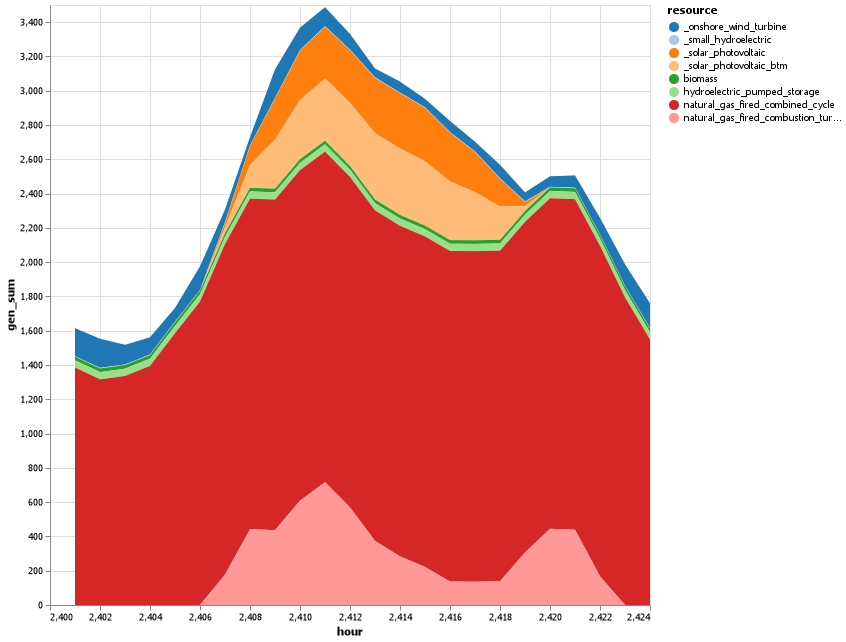

In [41]:
solution = economic_dispatch_multi_time(gen_df, loads_multi, gen_variable_multi);

sol_gen = innerjoin(solution.solution, 
                    gen_df[!, [:r_id, :resource]], 
                    on = :r_id)
sol_gen = combine(groupby(sol_gen, [:resource, :hour]), 
            :gen => sum)
sol_gen_btm = sol_gen
sol_gen_btm[sol_gen_btm.resource .== "solar_photovoltaic", :resource] .= "_solar_photovoltaic"
sol_gen_btm[sol_gen_btm.resource .== "onshore_wind_turbine", :resource] .= "_onshore_wind_turbine"
sol_gen_btm[sol_gen_btm.resource .== "small_hydroelectric", :resource] .= "_small_hydroelectric"

btm = DataFrame(resource = repeat(["_solar_photovoltaic_btm"]; outer=length(T_period)), 
    hour = T_period,
    gen_sum = gen_variable_multi[gen_variable_multi.gen_full .== "wec_sdge_solar_photovoltaic_1.0",:cf] * 600)
append!(sol_gen_btm, btm)

# Reorder resources
sort!(sol_gen_btm, [:hour, :resource])

sol_gen_btm |>
@vlplot(:area, 
    x=:hour, y={:gen_sum, stack=:zero}, 
    color={"resource:n", scale={scheme="category20"}},
    width=600,height=600)

In [42]:
# Save this stacked dispatch plot to file if you want to
sol_gen_btm |> FileIO.save("results/ED_moderate.png")

All errors:
ArgumentError: Package ImageIO [82e4d734-157c-48bb-816b-45c225c6df19] is required but does not seem to be installed:
 - Run `Pkg.instantiate()` to install all recorded dependencies.

ArgumentError: Package ImageMagick [6218d12a-5da1-5696-b52f-db25d2ecc6d1] is required but does not seem to be installed:
 - Run `Pkg.instantiate()` to install all recorded dependencies.

ArgumentError: Argument does not support conversion to png.


Errors encountered while save File{DataFormat{:PNG}, String}("results/ED_moderate.png").

Fatal error:


LoadError: ArgumentError: Package ImageIO [82e4d734-157c-48bb-816b-45c225c6df19] is required but does not seem to be installed:
 - Run `Pkg.instantiate()` to install all recorded dependencies.

Stacktrace:
  [1] [0m[1m_require[22m[0m[1m([22m[90mpkg[39m::[0mBase.PkgId[0m[1m)[22m
[90m    @ [39m[90mBase[39m [90m.\[39m[90m[4mloading.jl:1306[24m[39m
  [2] [0m[1m_require_prelocked[22m[0m[1m([22m[90muuidkey[39m::[0mBase.PkgId[0m[1m)[22m
[90m    @ [39m[90mBase[39m [90m.\[39m[90m[4mloading.jl:1200[24m[39m
  [3] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mlock.jl:223[24m[39m[90m [inlined][39m
  [4] [0m[1mrequire[22m[0m[1m([22m[90muuidkey[39m::[0mBase.PkgId[0m[1m)[22m
[90m    @ [39m[90mBase[39m [90m.\[39m[90m[4mloading.jl:1195[24m[39m
  [5] [0m[1m#34[22m
[90m    @ [39m[90mC:\Users\user\.julia\packages\FileIO\aP78L\src\[39m[90m[4mloadsave.jl:203[24m[39m[90m [inlined][39m
  [6] [0m[1mlock[22m[0m[1m([22m[90mf[39m::[0mFileIO.var"#34#35"[90m{Base.PkgId}[39m, [90ml[39m::[0mReentrantLock[0m[1m)[22m
[90m    @ [39m[90mBase[39m [90m.\[39m[90m[4mlock.jl:185[24m[39m
  [7] [0m[1maction[22m[0m[1m([22m[90mcall[39m::[0mSymbol, [90mlibraries[39m::[0mVector[90m{Union{Base.PkgId, Module}}[39m, [90mfile[39m::[0mFileIO.Formatted, [90margs[39m::[0mDataFrame; [90moptions[39m::[0mBase.Pairs[90m{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}[39m[0m[1m)[22m
[90m    @ [39m[35mFileIO[39m [90mC:\Users\user\.julia\packages\FileIO\aP78L\src\[39m[90m[4mloadsave.jl:203[24m[39m
  [8] [0m[1maction[22m
[90m    @ [39m[90mC:\Users\user\.julia\packages\FileIO\aP78L\src\[39m[90m[4mloadsave.jl:196[24m[39m[90m [inlined][39m
  [9] [0m[1maction[22m[0m[1m([22m[90mcall[39m::[0mSymbol, [90mlibraries[39m::[0mVector[90m{Union{Base.PkgId, Module}}[39m, [90msym[39m::[0mSymbol, [90mfile[39m::[0mString, [90margs[39m::[0mDataFrame; [90moptions[39m::[0mBase.Pairs[90m{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}[39m[0m[1m)[22m
[90m    @ [39m[35mFileIO[39m [90mC:\Users\user\.julia\packages\FileIO\aP78L\src\[39m[90m[4mloadsave.jl:185[24m[39m
 [10] [0m[1maction[22m
[90m    @ [39m[90mC:\Users\user\.julia\packages\FileIO\aP78L\src\[39m[90m[4mloadsave.jl:185[24m[39m[90m [inlined][39m
 [11] [0m[1m#27[22m
[90m    @ [39m[90mC:\Users\user\.julia\packages\FileIO\aP78L\src\[39m[90m[4mloadsave.jl:149[24m[39m[90m [inlined][39m
 [12] [0m[1m|>[22m[0m[1m([22m[90mx[39m::[0mDataFrame, [90mf[39m::[0mFileIO.var"#27#28"[90m{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, String, Vector{Union{Base.PkgId, Module}}, Symbol}[39m[0m[1m)[22m
[90m    @ [39m[90mBase[39m [90m.\[39m[90m[4moperators.jl:911[24m[39m
 [13] top-level scope
[90m    @ [39m[90m[4mIn[42]:2[24m[39m

Running HiGHS 1.4.0 [date: 1970-01-01, git hash: bcf6c0b22]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
208 rows, 589 cols, 957 nonzeros
116 rows, 528 cols, 712 nonzeros
116 rows, 528 cols, 712 nonzeros
Presolve : Reductions: rows 116(-1658); columns 528(-72); elements 712(-2788)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 24(54962.6) 0s
         35     8.0426374437e+05 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 35
Objective value     :  8.0426374437e+05
HiGHS run time      :          0.01


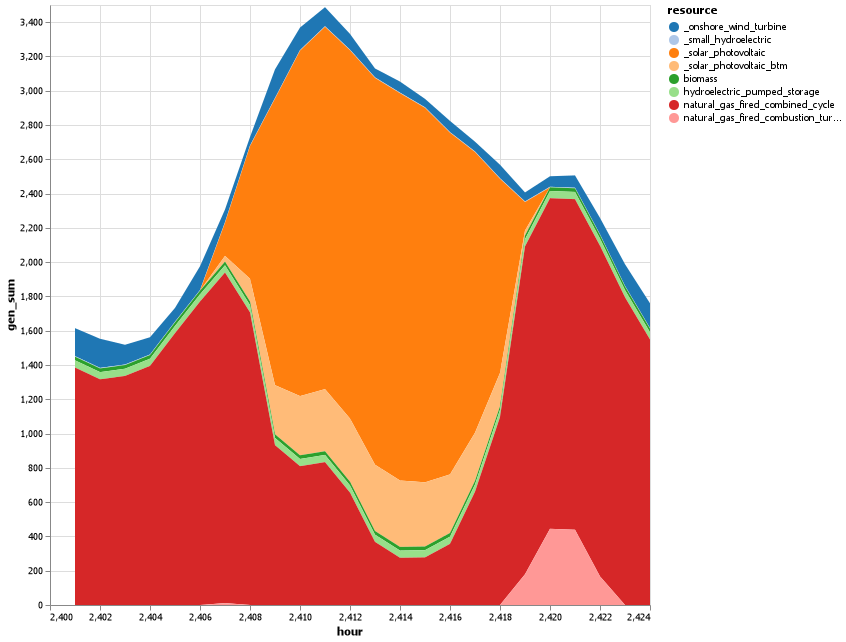

In [43]:
# Increase solar photovoltaic capacity
gen_df_sens = copy(gen_df)
gen_df_sens[gen_df_sens.resource .== "solar_photovoltaic",
    :existing_cap_mw] .= 3500

solution = economic_dispatch_multi_time(gen_df_sens, loads_multi, gen_variable_multi);

sol_gen = innerjoin(solution.solution, 
                    gen_df[!, [:r_id, :resource]], 
                    on = :r_id)

sol_gen = combine(groupby(sol_gen, [:resource, :hour]), 
            :gen => sum)
sol_gen_btm = copy(sol_gen)
sol_gen_btm[sol_gen_btm.resource .== "solar_photovoltaic", :resource] .= "_solar_photovoltaic"
sol_gen_btm[sol_gen_btm.resource .== "onshore_wind_turbine", :resource] .= "_onshore_wind_turbine"
sol_gen_btm[sol_gen_btm.resource .== "small_hydroelectric", :resource] .= "_small_hydroelectric"

btm = DataFrame(resource = repeat(["_solar_photovoltaic_btm"]; outer=length(T_period)), 
    hour = T_period,
    gen_sum = gen_variable_multi[gen_variable_multi.gen_full .== "wec_sdge_solar_photovoltaic_1.0",:cf] * 600)
append!(sol_gen_btm, btm)

# Reorder resources
sort!(sol_gen_btm, [:hour, :resource])

# Plot and save the resulting generation figure
p = sol_gen_btm |>
@vlplot(:area, 
    x=:hour, y={:gen_sum, stack=:zero}, 
    color={"resource:n", scale={scheme="category20"}},
    width=600,height=600)
save("results/sol_gen_btm.png",p)
p
     

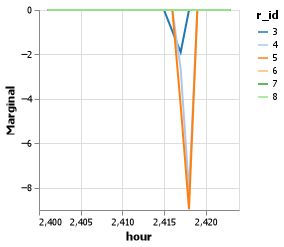

In [44]:
marg_gen = innerjoin(solution.marginals, 
                    gen_df[!, [:r_id, :resource]], 
                    on = :r_id)
marg_gen[marg_gen.resource .== "natural_gas_fired_combined_cycle",:] |>
@vlplot(:line, 
    x=:hour, y={:gen, title="Marginal"}, 
    color={"r_id:n", scale={scheme="category20"}})

     

In [45]:
marg_gen[argmin(marg_gen.gen),:]

Row,r_id,hour,gen,resource
,Int64?,Int64,Float64,String?
430,5,2418,-8.9672,natural_gas_fired_combined_cycle


In [46]:

varcost_comp = supply_curve[in.(supply_curve.r_id,Ref([5,9])),[:r_id,:varcost]]
varcost_comp

Row,r_id,varcost
,Int64?,Float64
1,5,29.3061
2,9,38.2733


In [47]:
varcost_comp[2,2] - varcost_comp[1,2]

8.967199999999998